Import the relevant packages, define the device, and fetch the JSON file that contains information about the images to
download:

In [34]:
!pip install -qU openimages torch_snippets urllib3

In [35]:
import torch
import torchvision

In [36]:
!pip install pycocotools

# Fetch the dataset from the Open Images dataset, which includes training images, their annotations, and the validation dataset:

In [37]:
!pip install torchtext==0.6.0

In [38]:
!pip install -qU openimages torch_snippets urllib3
!wget -O open_images_train_captions.jsonl -q https://storage.googleapis.com/localized-narratives/annotations/open_images_train_v6_captions.jsonl


In [39]:
# Import the relevant packages, define the device
from torch_snippets import *
import json
device = 'cuda' if torch.cuda.is_available() else 'cpu'

Loop through the content of the JSON file and fetch the information of the first 100,000 images

In [40]:
from tqdm import tqdm
import tqdm as tq
# rest of the code goes here
with open('open_images_train_captions.jsonl', 'r') as json_file:
    json_list = json_file.read().split('\n')
    np.random.shuffle(json_list)
    data = []
    N = 10000 # Doing 10000 instead of 100000 because cuda runs out of memory
    for ix, json_str in tqdm(enumerate(json_list), total=N):
        if ix == N:
            break
        try:
            result = json.loads(json_str)
            x = pd.DataFrame.from_dict(result, orient='index').T
            data.append(x)
        except:
            pass


100%|██████████| 10000/10000 [00:09<00:00, 1058.77it/s]


A sample of the information obtained from the JSON file is as follows:

In [41]:
result

{'dataset_id': 'open_images',
 'image_id': '9deb61a14c87ce52',
 'annotator_id': 32,
 'caption': 'This is a shipyard. On the right side there are few vehicles on the ground and there is a ship. On the left side I can see the water. In the background there are buildings and containers. At the top of the image I can see the sky. On the left side there is a person walking on the ground.'}

Split the dataframe (data) into training and validation datasets:

In [42]:
# Split the dataframe (data) into training and validation datasets
import pandas as pd
import numpy as np
from openimages.download import _download_images_by_id


In [43]:
!pip install torchsummary

In [44]:
# Split the dataframe (data) into training and validation datasets
np.random.seed(10)
data = pd.concat(data)
data['train'] = np.random.choice([True,False], size=len(data),p=[0.95,0.05])
data.to_csv('data.csv', index=False)


In [45]:
from openimages.download import _download_images_by_id
!mkdir -p train-images val-images

Download the images corresponding to the image IDs fetched from the JSON file:


In [46]:
#Download the images corresponding to the image IDs fetched from the JSON file:
subset_imageIds = data[data['train']].image_id.tolist()
print('--------------Train Images--------------')
_download_images_by_id(subset_imageIds, 'train', './train-images/')
print('--------------val Images--------------')
subset_imageIds = data[~data['train']].image_id.tolist()
_download_images_by_id(subset_imageIds, 'train', './val-images/')

--------------Train Images--------------

100%|██████████| 9530/9530 [03:58<00:00, 40.03it/s]


--------------val Images--------------

100%|██████████| 470/470 [00:12<00:00, 38.43it/s]


# Create a vocabulary of all the unique words present in all the captions in the dataframe:

In [47]:
def build_vocab(self, threshold=5):
    counter = Counter()
    for caption in self.captions:
        tokens = caption.split()
        counter.update(tokens)
    words = [word for word, count in counter.items() if count >= threshold]
    self.vocab = Vocab(words)


In [48]:
# A vocabulary object is something that can map every word in all the captions to a unique integer and vice versa
from torchtext.data import Field
from pycocotools.coco import COCO
from collections import defaultdict

captions = Field(sequential=False, init_token='<start>', eos_token='<end>')
all_captions = data[data['train']]['caption'].tolist()
all_tokens = [[w.lower() for w in c.split()] for c in all_captions]
all_tokens = [w for sublist in all_tokens for w in sublist]
captions.build_vocab(all_tokens)


In [49]:
# Captions vocabulary components
class Vocab:
    pass

vocab = Vocab()

captions.vocab.itos.insert(0, '<pad>')
vocab.itos = captions.vocab.itos

vocab.stoi = defaultdict(lambda: captions.vocab.itos.index('<unk>'))
vocab.stoi['<pad>'] = 0

for s, i in captions.vocab.stoi.items():
    vocab.stoi[s] = i + 1


# Define the dataset class – CaptioningDataset:

In [50]:
# Dataset class
from torchvision import transforms
from torch.utils.data import Dataset
from PIL import Image
import os

class CaptioningDataset(Dataset):
    def __init__(self, root, df, vocab):
        self.df = df.reset_index(drop=True)
        self.root = root
        self.vocab = vocab
        self.transform = transforms.Compose([
            transforms.Resize(224),
            transforms.RandomCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406),
                                 (0.229, 0.224, 0.225))
        ])
    # Returns one data pair (image and caption)

    def __getitem__(self, index):
        """Returns one data pair (image and caption)."""
        row = self.df.iloc[index].squeeze()
        id = row.image_id
        image_path = f'{self.root}/{id}.jpg'
        image = Image.open(os.path.join(image_path)).convert('RGB')
        caption = row.caption
        tokens = str(caption).lower().split()
        target = []
        target.append(self.vocab.stoi['<start>'])
        for token in tokens:
            if token in self.vocab.stoi:
                target.append(self.vocab.stoi[token])
        target.append(self.vocab.stoi['<end>'])
        target = torch.Tensor(target).long()
        return image, target, caption

    def choose(self):
        return self[np.random.randint(len(self))]

    def __len__(self):
        return len(self.df)
    # Creates batch of captions and padds captions to be equal length

    def collate_fn(self, data):
        data.sort(key=lambda x: len(x[1]), reverse=True)
        images, targets, captions = zip(*data)
        images = torch.stack([self.transform(image) for image in images], 0)
        lengths = [len(tar) for tar in targets]
        _targets = torch.zeros(len(captions), max(lengths)).long()
        for i, tar in enumerate(targets):
            end = lengths[i]
            _targets[i, :end] = tar[:end]
        return images.to(device), _targets.to(device), torch.tensor(lengths).long().to(device)


# Define the training and validation dataset and data loaders:


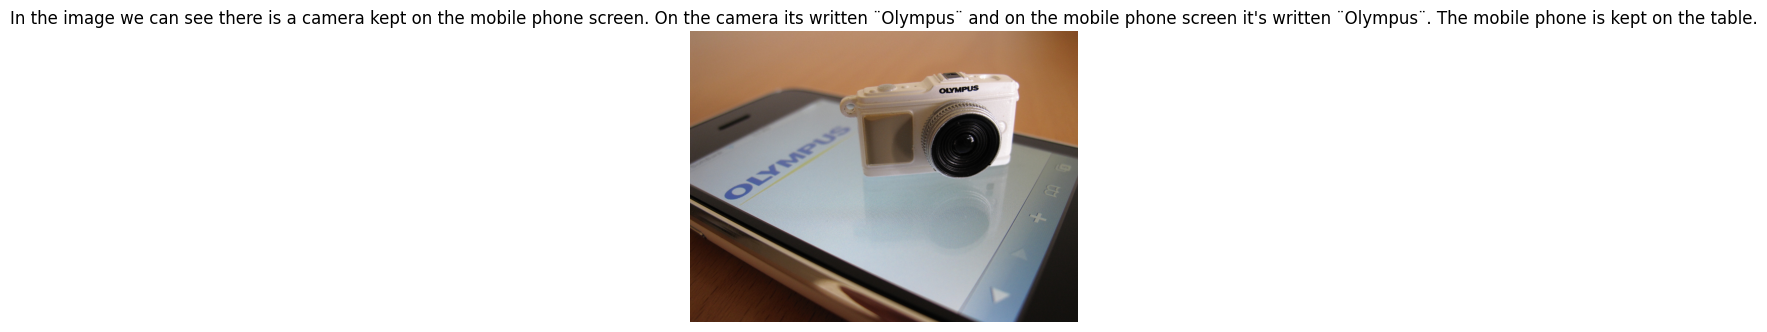

tensor([   2,    6,    4,   17,   13,   11,   10,    8,    9,    5,  317,  214,
          12,    4,  332,  522,  315,   12,    4,  317,  503,  143, 5632,    7,
          12,    4,  332,  522,  251,  932,  143, 5633,    4,  332,  522,    9,
         214,   12,    4,   72,    3])

In [51]:
#Define the training and validation dataset and data loaders

trn_ds = CaptioningDataset('train-images', data[data['train']], vocab)
val_ds = CaptioningDataset('val-images', data[~data['train']], vocab)

image, target, caption = trn_ds.choose()

# Show sample image and caption

show(image, title=caption, sz=5)
print(target)


# Create the dataloaders for the datasets:

In [52]:

trn_dl = DataLoader(trn_ds, 32, collate_fn=trn_ds.collate_fn)
val_dl = DataLoader(val_ds, 32, collate_fn=val_ds.collate_fn)



In [53]:
for batch in trn_dl:
    images, targets, lengths = batch
    print("Images:", images)
    print("Targets:", targets)
    print("Lengths:", lengths)
    break

Images: tensor([[[[ 1.9578,  1.9920,  1.9749,  ...,  1.9920,  1.9749,  1.9578],
          [ 1.9578,  1.9578,  1.9578,  ...,  1.9749,  1.9578,  1.9578],
          [ 1.9749,  1.9407,  1.9749,  ...,  1.9578,  1.9407,  1.9749],
          ...,
          [ 1.8893,  1.9235,  1.9064,  ...,  1.9064,  1.9064,  1.8550],
          [ 1.8893,  1.8893,  1.8893,  ...,  1.9064,  1.8893,  1.8550],
          [ 1.8722,  1.8208,  1.8550,  ...,  1.8722,  1.8379,  1.8893]],

         [[ 2.1310,  2.1660,  2.1485,  ...,  2.1660,  2.1485,  2.1310],
          [ 2.1310,  2.1310,  2.1310,  ...,  2.1485,  2.1310,  2.1310],
          [ 2.1485,  2.1134,  2.1485,  ...,  2.1310,  2.1134,  2.1485],
          ...,
          [ 1.9734,  2.0084,  1.9909,  ...,  1.9909,  2.0084,  1.9909],
          [ 1.9909,  1.9909,  1.9909,  ...,  1.9909,  1.9909,  1.9909],
          [ 1.9909,  1.9559,  1.9909,  ...,  1.9559,  1.9384,  2.0259]],

         [[ 2.1694,  2.2043,  2.1868,  ...,  2.2043,  2.1868,  2.1694],
          [ 2.1694,  2.1694,  2.1694,  ...,  2.1868,  2.1694,  2.1694],
          [ 2.1868,  2.1520,  2.1868,  ...,  2.1694,  2.1520,  2.1868],
          ...,
          [ 1.8034,  1.8383,  1.8208,  ...,  1.8208,  1.8383,  1.8034],
          [ 1.8034,  1.8208,  1.8208,  ...,  1.8208,  1.8208,  1.8034],
          [ 1.8034,  1.7685,  1.8034,  ...,  1.7860,  1.7685,  1.8383]]],


        [[[ 0.9817,  1.0844,  1.1529,  ...,  0.7933,  0.5878,  0.5364],
          [ 1.0331,  1.0502,  1.1015,  ...,  0.8104,  0.5193,  0.4508],
          [ 1.1358,  1.0844,  1.0673,  ...,  0.8789,  0.5364,  0.4851],
          ...,
          [ 0.5022, -0.0972, -0.0458,  ...,  0.5707,  0.5707,  0.5193],
          [ 0.6049,  0.1426,  0.1768,  ...,  0.6392,  0.5707,  0.6049],
          [ 0.6734,  0.2282,  0.1768,  ...,  0.7419,  0.5707,  0.5536]],

         [[ 1.0630,  1.1856,  1.2381,  ...,  0.8704,  0.6604,  0.5903],
          [ 1.0805,  1.1331,  1.1506,  ...,  0.8880,  0.5903,  0.5203],
          [ 1.1155,  1.0630,  1.0630,  ...,  0.9580,  0.6078,  0.5553],
          ...,
          [ 0.4328, -0.2150, -0.1625,  ...,  0.6954,  0.6954,  0.6254],
          [ 0.6429,  0.1877,  0.2052,  ...,  0.8529,  0.7829,  0.8004],
          [ 0.8179,  0.3627,  0.2752,  ...,  0.9230,  0.7479,  0.6954]],

         [[ 0.7576,  0.8622,  0.9319,  ...,  1.0714,  0.8797,  0.8622],
          [ 0.7751,  0.8274,  0.8622,  ...,  1.0539,  0.7925,  0.7402],
          [ 0.8274,  0.7751,  0.7751,  ...,  1.1062,  0.7925,  0.7576],
          ...,
          [ 0.4788, -0.1661, -0.1487,  ..., -0.1312, -0.0964, -0.0615],
          [ 0.7402,  0.2871,  0.2871,  ..., -0.0790, -0.0615,  0.0605],
          [ 0.9668,  0.4962,  0.4614,  ...,  0.0256, -0.0441,  0.0256]]],


        [[[-0.7650, -0.7479, -0.7137,  ..., -0.9192, -0.9192, -0.8849],
          [-1.0048, -0.9705, -0.9363,  ..., -0.8335, -0.8678, -0.8849],
          [-1.2617, -1.2445, -1.2274,  ..., -0.7479, -0.7479, -0.7650],
          ...,
          [-1.8953, -1.9124, -1.9809,  ..., -1.0562, -1.0733, -1.1075],
          [-1.8782, -1.9124, -1.9638,  ..., -1.0904, -1.0733, -1.1589],
          [-1.8439, -1.8782, -1.9295,  ..., -1.1760, -1.1418, -1.1760]],

         [[-1.1604, -1.1604, -1.1253,  ..., -1.4580, -1.4580, -1.4230],
          [-1.3354, -1.3004, -1.2654,  ..., -1.4055, -1.4230, -1.4405],
          [-1.5105, -1.4930, -1.4755,  ..., -1.3354, -1.3354, -1.3529],
          ...,
          [-1.8606, -1.8606, -1.8081,  ..., -0.9328, -0.9503, -0.9853],
          [-1.8606, -1.8606, -1.8256,  ..., -0.9678, -0.9503, -1.0378],
          [-1.8782, -1.8782, -1.8431,  ..., -1.0553, -1.0203, -1.0553]],

         [[-1.2816, -1.2816, -1.2467,  ..., -1.5081, -1.5081, -1.4733],
          [-1.3687, -1.3339, -1.2990,  ..., -1.4733, -1.4907, -1.5081],
          [-1.4384, -1.4210, -1.3861,  ..., -1.4036, -1.4036, -1.4384],
          ...,
          [-1.6302, -1.5779, -1.5953,  ..., -0.6715, -0.6890, -0.7238],
          [-1.6302, -1.5779, -1.5953,  ..., -0.7064, -0.6890, -0.7761],
          [-1.6127, -

Targets: tensor([[ 2,  6, 15,  ...,  4, 54,  3],
        [ 2,  6, 15,  ...,  0,  0,  0],
        [ 2,  6,  4,  ...,  0,  0,  0],
        ...,
        [ 2,  8,  9,  ...,  0,  0,  0],
        [ 2,  6, 15,  ...,  0,  0,  0],
        [ 2, 15,  9,  ...,  0,  0,  0]], device='cuda:0')

Lengths: tensor([78, 70, 66, 54, 51, 48, 43, 43, 41, 40, 36, 34, 33, 33, 32, 31, 30, 27,
        27, 24, 24, 23, 23, 22, 22, 21, 16, 15, 15, 15, 12, 10],
       device='cuda:0')

# Define the network class:


In [54]:
from torch.nn.utils.rnn import pack_padded_sequence
from torchvision import models
# The network class - EncoderCNN

class EncoderCNN(nn.Module):
      # Load the pretrained ResNet-152 and replace top fc layer

    def __init__(self, embed_size):
        """Load the pretrained ResNet-152 and replace top fc layer."""
        super(EncoderCNN, self).__init__()
        resnet = models.resnet152(pretrained=True)
        # delete the last fc layer.
        modules = list(resnet.children())[:-1]
        # Connect it to a linear layer
        self.resnet = nn.Sequential(*modules)
        self.linear = nn.Linear(resnet.fc.in_features, embed_size)
        # Pass it through batch normalization
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)
    # Extract feature vectors from input images
    def forward(self, images):
        """Extract feature vectors from input images."""
        with torch.no_grad():
            features = self.resnet(images)
            features = features.reshape(features.size(0), -1)
            features = self.bn(self.linear(features))
        return features


In [55]:
# Creating encoder instance
encoder = EncoderCNN(256).to(device)

In [56]:
import os
os.environ['CUDNN_BENCHMARK'] = 'True'

In [57]:
from torchsummary import summary
print(summary(encoder.to(device),(3,224,224)))
# print(summary(encoder,torch.zeros(32,3,224,224).to(device)))
# size = (32,3,244,244)
# tensor = torch.rand(*size)
# print(tensor)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

None

In [58]:
# Define the decoder architecture – DecoderRNN
class DecoderRNN(nn.Module):
  # Set the hyper-parameters and build the layers
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers, max_seq_length=80):
        """Set the hyper-parameters and build the layers."""
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.max_seq_length = max_seq_length
# Decode image feature vectors and generates captions
    def forward(self, features, captions, lengths):
        """Decode image feature vectors and generates captions."""
        embeddings = self.embed(captions)
        embeddings = torch.cat((features.unsqueeze(1), embeddings), 1)
        packed = pack_padded_sequence(embeddings, lengths.cpu(), batch_first=True)
        outputs, _ = self.lstm(packed)
        outputs = self.linear(outputs[0])
        return outputs
#Generate captions for given image features using greedy search
    def predict(self, features, vocab, states=None):
      """Generate captions for given image features using greedy search."""
      sampled_ids = []
      inputs = features.unsqueeze(1)
      for i in range(self.max_seq_length):
          hiddens, states = self.lstm(inputs, states)
          # hiddens: (batch_size, 1, hidden_size)
          outputs = self.linear(hiddens.squeeze(1))
          # outputs: (batch_size, vocab_size)
          _, predicted = outputs.max(1)
          # predicted: (batch_size)
          sampled_ids.append(predicted)
          if predicted == vocab.stoi['<end>']:
              break
          inputs = self.embed(predicted)
          # inputs: (batch_size, embed_size)
          inputs = inputs.unsqueeze(1)
          # inputs: (batch_size, 1, embed_size)
      sampled_ids = torch.stack(sampled_ids, 1)
      # sampled_ids: (batch_size, max_seq_length)
      # convert predicted tokens to strings
      sentences = []
      for sampled_id in sampled_ids:
          sampled_id = sampled_id.cpu().numpy()
          sampled_caption = []
          for word_id in sampled_id:
              word = vocab.itos[word_id]
              if word == '<end>':
                  break
              sampled_caption.append(word)
          sentence = ' '.join(sampled_caption)
          sentences.append(sentence)
      return sentences


In [59]:
#@title
# testing

class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers, max_seq_length=80):
        """Set the hyper-parameters and build the layers."""
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.max_seq_length = max_seq_length

    def forward(self, features, captions, lengths):
        """Decode image feature vectors and generates captions."""
        embeddings = self.embed(captions)
        embeddings = torch.cat((features.unsqueeze(1), embeddings), 1)
        packed = pack_padded_sequence(embeddings, lengths.cpu(), batch_first=True)
        outputs, _ = self.lstm(packed)
        outputs = self.linear(outputs[0])
        return outputs

    def predict(self, features, vocab, states=None):
      """Generate captions for given image features using greedy search."""
      sampled_ids = []
      inputs = features.unsqueeze(1)
      for i in range(self.max_seq_length):
          hiddens, states = self.lstm(inputs, states)
          # hiddens: (batch_size, 1, hidden_size)
          outputs = self.linear(hiddens.squeeze(1))
          # outputs: (batch_size, vocab_size)
          _, predicted = outputs.max(1)
          # predicted: (batch_size)
          sampled_ids.append(predicted)
          if predicted == vocab.stoi['<end>']:
              break
          inputs = self.embed(predicted)
          # inputs: (batch_size, embed_size)
          inputs = inputs.unsqueeze(1)
          # inputs: (batch_size, 1, embed_size)
      sampled_ids = torch.stack(sampled_ids, 1)
      # sampled_ids: (batch_size, max_seq_length)
      # convert predicted tokens to strings
      sentences = []
      for sampled_id in sampled_ids:
          sampled_id = sampled_id.cpu().numpy()
          sampled_caption = []
          for word_id in sampled_id:
              word = vocab.itos[word_id]
              if word == '<end>':
                  break
              sampled_caption.append(word)
          sentence = ' '.join(sampled_caption)
          sentences.append(sentence)
      return sentences

    def predict_caption_img(self, image_path, vocab, states=None):
      image_id = os.path.splitext(os.path.basename(image_path))[0]
      with open('open_images_train_captions.jsonl', 'r') as json_file:
          for line in json_file:
              data_dict = json.loads(line)
              if data_dict['image_id'] == image_id:
                  predicted_caption = data_dict['caption']
                  break
      return predicted_caption


# Define the functions to train on a batch of data:

In [60]:
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence
# Trains on a single batch of data

def train_batch(data, encoder, decoder, optimizer, criterion):
    encoder.train()
    decoder.train()
    images, captions, lengths = data
    images = images.to(device)
    captions = captions.to(device)
    targets = pack_padded_sequence(captions, lengths.cpu(), batch_first=True)[0]
    features = encoder(images)
    outputs = decoder(features, captions, lengths)
    loss = criterion(outputs, targets)
    decoder.zero_grad()
    encoder.zero_grad()
    loss.backward()
    optimizer.step()
    return loss


# Define the function to validate on a batch of data:

In [61]:
# Validate on a batch of data
@torch.no_grad()
def validate_batch(data, encoder, decoder, criterion):
    encoder.eval()
    decoder.eval()
    images, captions, lengths = data
    images = images.to(device)
    captions = captions.to(device)
    targets = pack_padded_sequence(captions, lengths.cpu(), batch_first=True)[0]
    features = encoder(images)
    outputs = decoder(features, captions, lengths)
    loss = criterion(outputs, targets)
    return loss


In [62]:
import torch.cuda
torch.cuda.is_available()

True

# Define the model objects and the loss function, and optimizer:


In [63]:
# Define encoder, decoder, loss function, and optimizer
import torch.backends.cudnn as cudnn
cudnn.deterministic = True

encoder = EncoderCNN(256).to(device)
decoder = DecoderRNN(256, 512, len(vocab.itos), 1).to(device)
criterion = nn.CrossEntropyLoss()
params = list(decoder.parameters()) + \
         list(encoder.linear.parameters()) + \
         list(encoder.bn.parameters())
optimizer = torch.optim.AdamW(params, lr=1e-3)
n_epochs = 5
log = Report(n_epochs)


# Train the model over increasing epochs:

EPOCH: 1.000  trn_loss: 3.387  val_loss: 2.626  (236.22s - 944.87s remaining)
EPOCH: 2.000  trn_loss: 2.512  val_loss: 2.421  (462.78s - 694.17s remaining)
EPOCH: 3.000  trn_loss: 2.279  val_loss: 2.299  (696.04s - 464.03s remaining)
EPOCH: 4.000  trn_loss: 2.119  val_loss: 2.227  (930.35s - 232.59s remaining)
EPOCH: 5.000  trn_loss: 1.988  val_loss: 2.188  (1173.38s - 0.00s remaining)


100%|██████████| 106/106 [00:00<00:00, 1191.93it/s]


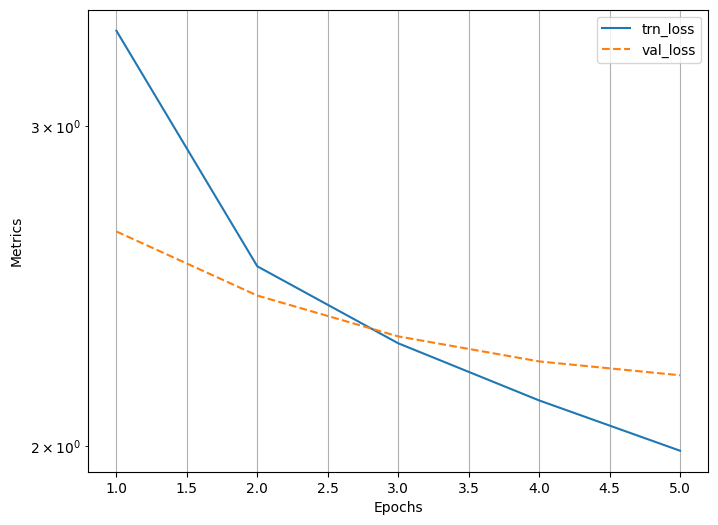

In [64]:
# Train the model over increasing epochs
for epoch in range(n_epochs):
    if epoch == 5:
        optimizer = torch.optim.AdamW(params, lr=1e-4)

    N = len(trn_dl)
    for i, data in enumerate(trn_dl):
        trn_loss = train_batch(data, encoder, decoder, optimizer, criterion)
        pos = epoch + (1+i)/N
        log.record(pos=pos, trn_loss=trn_loss, end='\r')

    N = len(val_dl)
    for i, data in enumerate(val_dl):
        val_loss = validate_batch(data, encoder, decoder, criterion)
        pos = epoch + (1-0+i)/N
        log.record(pos=pos, val_loss=val_loss, end='\r')

    log.report_avgs(epoch+1)

log.plot_epochs(log=True)


# Define a function that generates predictions given an image:

In [65]:
#Generates predictions given an image
def load_image(image_path, transform=None):
    image = Image.open(image_path).convert('RGB')
    image = image.resize([224, 224], Image.LANCZOS)

    if transform is not None:
        tfm_image = transform(image)[None]

    return image, tfm_image

def load_image_and_predict(image_path, vocab):
    transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
                                    ])
    org_image, tfm_image = load_image(image_path, transform)
    feaature = image_path
    image_tensor = tfm_image.to(device)
    encoder.eval()
    decoder.eval()
    feature = encoder(image_tensor)
    sentence = decoder.predict_caption_img(feaature, vocab)
    show(org_image, title=f'<start> {sentence} <end>',sz=5)
    return sentence


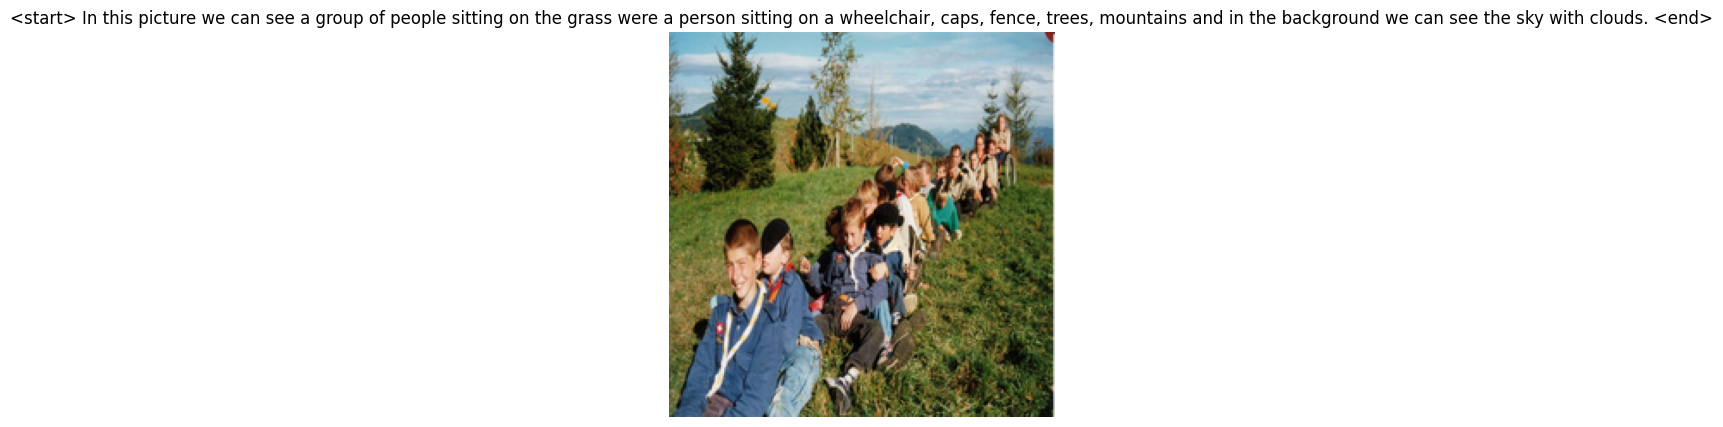

In [66]:
# Predict an image
files = Glob('val-images')
predicted_captions = load_image_and_predict(choose(files),vocab)